# Dataset | Problem

Context:

Attribute Information:

Data vocabulary:

Acknowledgements:
(Confidential Source) - Use only for educational purposes
If you use this dataset in your research, please credit the author.

# Import Libraries

In [1]:
# 1-Import Libraies

#!pip install lightgbm
#!pip install catboost

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
%matplotlib notebook
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#Model Selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import KFold, cross_val_predict

#Feature Selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression

#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesRegressor

from xgboost import XGBClassifier
from xgboost import plot_importance

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPRegressor

#Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


#Metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 


#Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

#Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Useful Functions

In [54]:
## Useful Functions

###############################################################################

def first_looking(column):
    print("column name    : ", column) 
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[column].isnull().sum())
    print("num_of_uniques : ", df[column].nunique())
    print("value_counts : ", df[column].value_counts(dropna = False).head())
    
# for i in df.columns:
#     first_looking(i)

###############################################################################

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

###############################################################################

def perc_nans(serial):  # Ex:perc_nans(df['kW'])
    # display percentage of nans in a Series
    return serial.isnull().sum()/serial.shape[0]*100

def perc_nans_byLimitless(df):
    return df.isnull().sum()/df.shape[0]*100

def perc_nans_byLimit(df, limit):
    missing = df.isnull().sum()*100/df.shape[0]
    return missing.loc[lambda x : x >= limit]

# perc_nans_byLimit(df, 90)

###############################################################################

def fill_median(df, group_col, col_name):
    '''Fills the missing values with the most existing value (median) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        median = list(df[cond][col_name].median())
        if median != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].median()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].median()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def fill(df, group_col1, group_col2, col_name, method): # method can be "mode" or "median" or "ffill"
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])
                
    elif method == "median":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].median()).fillna(df[cond1][col_name].median()).fillna(df[col_name].median())
                
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def model_validation(y_train, y_train_pred, y_test, y_test_pred, model_name):
    
    scores =  {f"{model_name}_train": {"R2" : r2_score(y_train, y_train_pred),
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "mse" : mean_squared_error(y_train, y_train_pred), 
    "mae" : mean_absolute_error(y_train, y_train_pred)},
    
    f"{model_name}_test": {"R2" : r2_score(y_test, y_test_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "mse" : mean_squared_error(y_test, y_test_pred),
    "mae" : mean_absolute_error(y_test, y_test_pred)}}
     
    return pd.DataFrame(scores)

# lm = model_validation(y_train, y_train_pred, y_test, y_test_pred, 'lm')

# pd.concat([lm, rs, rcvs, lss, lcvs, es, ecvs], axis = 1)

###############################################################################

def get_classification_report(y_test, y_test_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_test_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    #df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

###############################################################################

def shape_control():
    print('df.shape:', df.shape)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    print('X_test.shape:', X_test.shape)
    print('y_test.shape:', y_test.shape)
    try:
        print('y_test_pred.shape:', y_test_pred.shape)
    except:
        print()
        
###############################################################################

def calc_predict():
    return accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)
    
def get_report():
    from sklearn import metrics
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    y_train_pred = model.predict(X_train_scaled)
    try:
        y_train_pred_proba = model.predict_proba(X_train_scaled)
    except:
        print()
    try:
        precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba[:,1])
    except:
        print() 
    try:
        y_test_pred_proba = model.predict_proba(X_test_scaled)
    except:
        print()
    try:
        precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba[:,1])
    except:
        print()  
    print('Model:', model.get_params, '\n')
    try:
        print('model.best_params_:', model.best_params_, '\n')
    except:
        print()
    print("Train:")
    print('rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print('accuracy:', accuracy_score(y_train, y_train_pred))
    try:
        print('roc_auc_score:',roc_auc_score(y_train, y_train_pred_proba[:,1]))
    except:
        print()
    try:
        print('roc_auc_recall_precision_score:',auc(recall, precision),'\n')
    except:
        print()
    print('confusion_matrix:\n\n', confusion_matrix(y_train, y_train_pred), '\n')
    print('classification_report:\n\n', classification_report(y_train, y_train_pred),'\n')
    print()
    print("Test:")
    print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred))) 
    print('accuracy:', accuracy_score(y_test, y_test_pred))
    try:
        print('roc_auc_score:',roc_auc_score(y_test, y_test_pred_proba[:,1]))
    except:
        print() 
    try:
        print('roc_auc_recall_precision_score:',auc(recall, precision),'\n')
    except:
        print() 
    print('confusion_matrix:\n\n', confusion_matrix(y_test, y_test_pred), '\n')
    print('classification_report:\n\n', classification_report(y_test, y_test_pred))

def train_control_table():
    y_train_pred = model.predict(X_train_scaled)
    y_train_pred = pd.DataFrame(y_train_pred)
    y_train_pred.rename(columns = {0: 'y_train_pred'}, inplace = True)
    return pd.concat([X_train, y_train, y_train_pred.set_index(y_train.index)], axis=1)

def test_control_table():
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred = pd.DataFrame(y_test_pred)
    y_test_pred.rename(columns = {0: 'y_test_pred'}, inplace = True)
    return pd.concat([X_test, y_test, y_test_pred.set_index(y_test.index)], axis=1)

###############################################################################

def feature_importances():
    df_fi = pd.DataFrame(index=X.columns, 
                         data=model.feature_importances_, 
                         columns=["Feature Importance"]).sort_values("Feature Importance")

    return df_fi.sort_values(by="Feature Importance", ascending=False).T

def feature_importances_bar():
    df_fi = pd.DataFrame(index=X.columns, 
                         data=model.feature_importances_, 
                         columns=["Feature Importance"]).sort_values("Feature Importance")
    sns.barplot(data = df_fi, 
                x = df_fi.index, 
                y = 'Feature Importance', 
                order=df_fi.sort_values('Feature Importance', ascending=False).reset_index()['index'])
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show();

# Load | Read Data

In [3]:
# 2-Load|Read Data
csv_path = "water_potability.csv"
df0 = pd.read_csv(csv_path)
df = df0.copy() 
# drop_columns = "id"
# df.head()
# df.shape
# df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
# df.nunique()
# df.info()
# df.shape
# df.isnull().sum()
# missing(df)
# df.drop(drop_columns, axis=1, inplace=True)
# df.shape
# df.describe().T
# df.columns

In [4]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890,20791.319,7.300,368.516,564.309,10.380,86.991,2.963,0
1,3.716,129.423,18630.058,6.635,NaN,592.885,15.180,56.329,4.501,0
2,8.099,224.236,19909.542,9.276,NaN,418.606,16.869,66.420,3.056,0
3,8.317,214.373,22018.417,8.059,356.886,363.267,18.437,100.342,4.629,0
4,9.092,181.102,17978.986,6.547,310.136,398.411,11.558,31.998,4.075,0


In [5]:
df.shape

(3276, 10)

In [6]:
df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

In [7]:
df.nunique()

ph                 2785
hardness           3276
solids             3276
chloramines        3276
sulfate            2495
conductivity       3276
organic_carbon     3276
trihalomethanes    3114
turbidity          3276
potability            2
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   hardness         3276 non-null   float64
 2   solids           3276 non-null   float64
 3   chloramines      3276 non-null   float64
 4   sulfate          2495 non-null   float64
 5   conductivity     3276 non-null   float64
 6   organic_carbon   3276 non-null   float64
 7   trihalomethanes  3114 non-null   float64
 8   turbidity        3276 non-null   float64
 9   potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [9]:
df.isnull().sum()

ph                 491
hardness             0
solids               0
chloramines          0
sulfate            781
conductivity         0
organic_carbon       0
trihalomethanes    162
turbidity            0
potability           0
dtype: int64

In [10]:
missing(df)

,Missing_Number,Missing_Percent
sulfate,781,0.238
ph,491,0.150
trihalomethanes,162,0.049
hardness,0,0.000
solids,0,0.000
chloramines,0,0.000
conductivity,0,0.000
organic_carbon,0,0.000
turbidity,0,0.000
potability,0,0.000


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ph,2785.000,7.081,1.594,0.000,6.093,7.037,8.062,14.000
hardness,3276.000,196.369,32.880,47.432,176.851,196.968,216.667,323.124
solids,3276.000,22014.093,8768.571,320.943,15666.690,20927.834,27332.762,61227.196
chloramines,3276.000,7.122,1.583,0.352,6.127,7.130,8.115,13.127
sulfate,2495.000,333.776,41.417,129.000,307.699,333.074,359.950,481.031
conductivity,3276.000,426.205,80.824,181.484,365.734,421.885,481.792,753.343
organic_carbon,3276.000,14.285,3.308,2.200,12.066,14.218,16.558,28.300
trihalomethanes,3114.000,66.396,16.175,0.738,55.845,66.622,77.337,124.000
turbidity,3276.000,3.967,0.780,1.450,3.440,3.955,4.500,6.739
potability,3276.000,0.390,0.488,0.000,0.000,0.000,1.000,1.000


In [12]:
df.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity', 'potability'],
      dtype='object')

In [13]:
df.sulfate.describe()

count   2495.000
mean     333.776
std       41.417
min      129.000
25%      307.699
50%      333.074
75%      359.950
max      481.031
Name: sulfate, dtype: float64

In [14]:
df.ph.describe()

count   2785.000
mean       7.081
std        1.594
min        0.000
25%        6.093
50%        7.037
75%        8.062
max       14.000
Name: ph, dtype: float64

In [15]:
df.trihalomethanes.describe()

count   3114.000
mean      66.396
std       16.175
min        0.738
25%       55.845
50%       66.622
75%       77.337
max      124.000
Name: trihalomethanes, dtype: float64

In [16]:
# outlierlarla ilgili detayli bir calisma yapilmasi  gerekiyor, icilebilir su aralginda olmayaipda icilebilir 
# olarak siniflandirilmis veriler outlier kapsaminina alinabilir, sonra calisilcak
# Hem doğal kaynaklarda hem de içme sularında suyun pH değeri 
# hafif alkali veya nötr olmalıdır. Ayrıca kaynak sularında en uygun 
# pH değeri 6,5 ile 8,5 arası olmalıyken 
# içme sularında ise 6,5 ve 9,2 arası olmalıdır.
# minimum 10 (FSº) sertlik derecesinde olmasını önermektedir.


In [17]:
import missingno as msno 

<IPython.core.display.Javascript object>


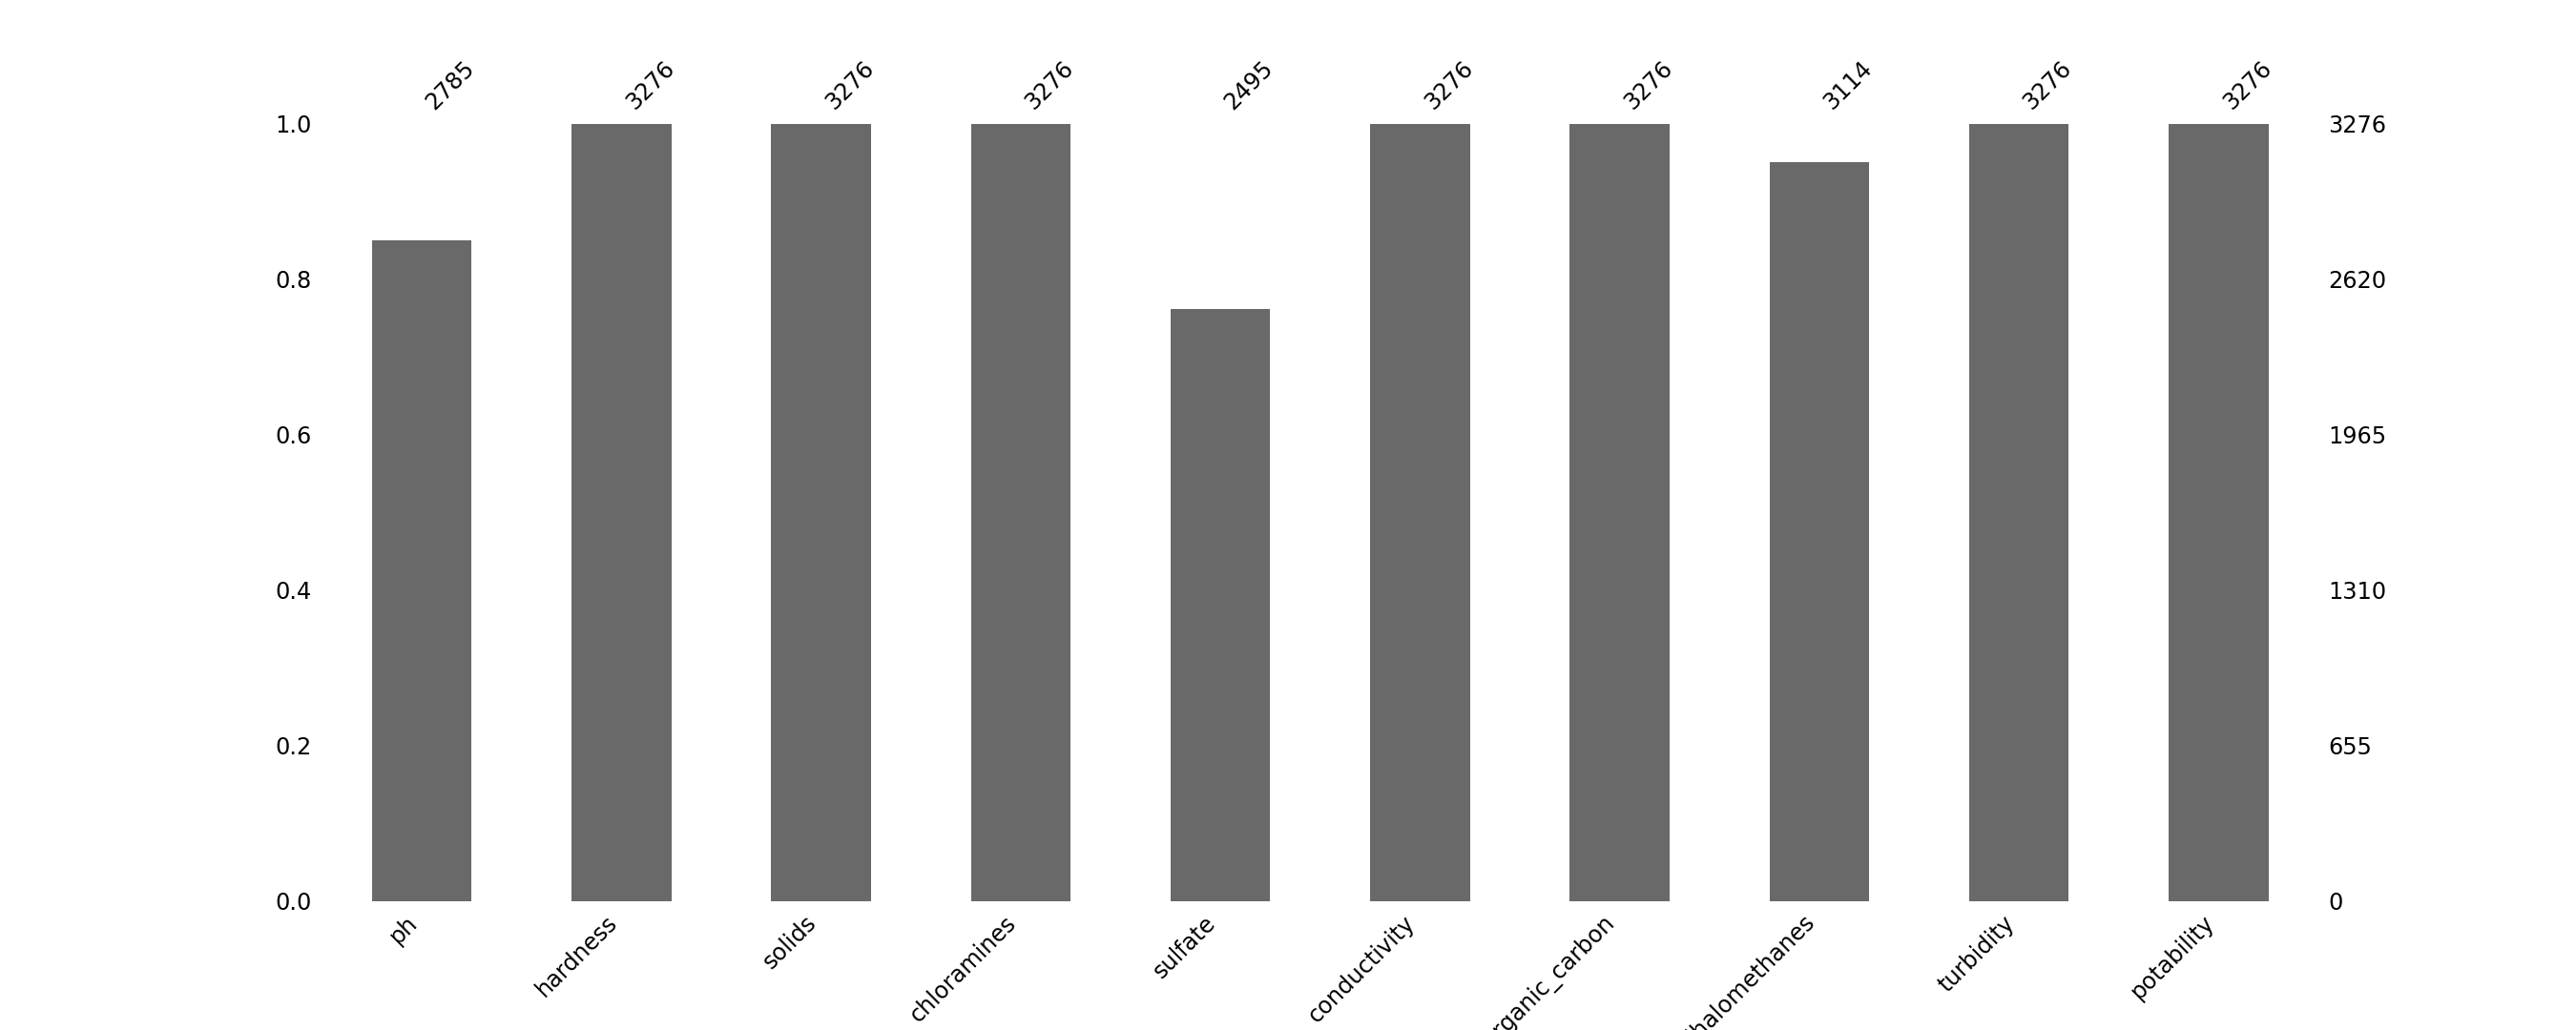

<AxesSubplot:>

In [18]:
msno.bar(df)

<IPython.core.display.Javascript object>


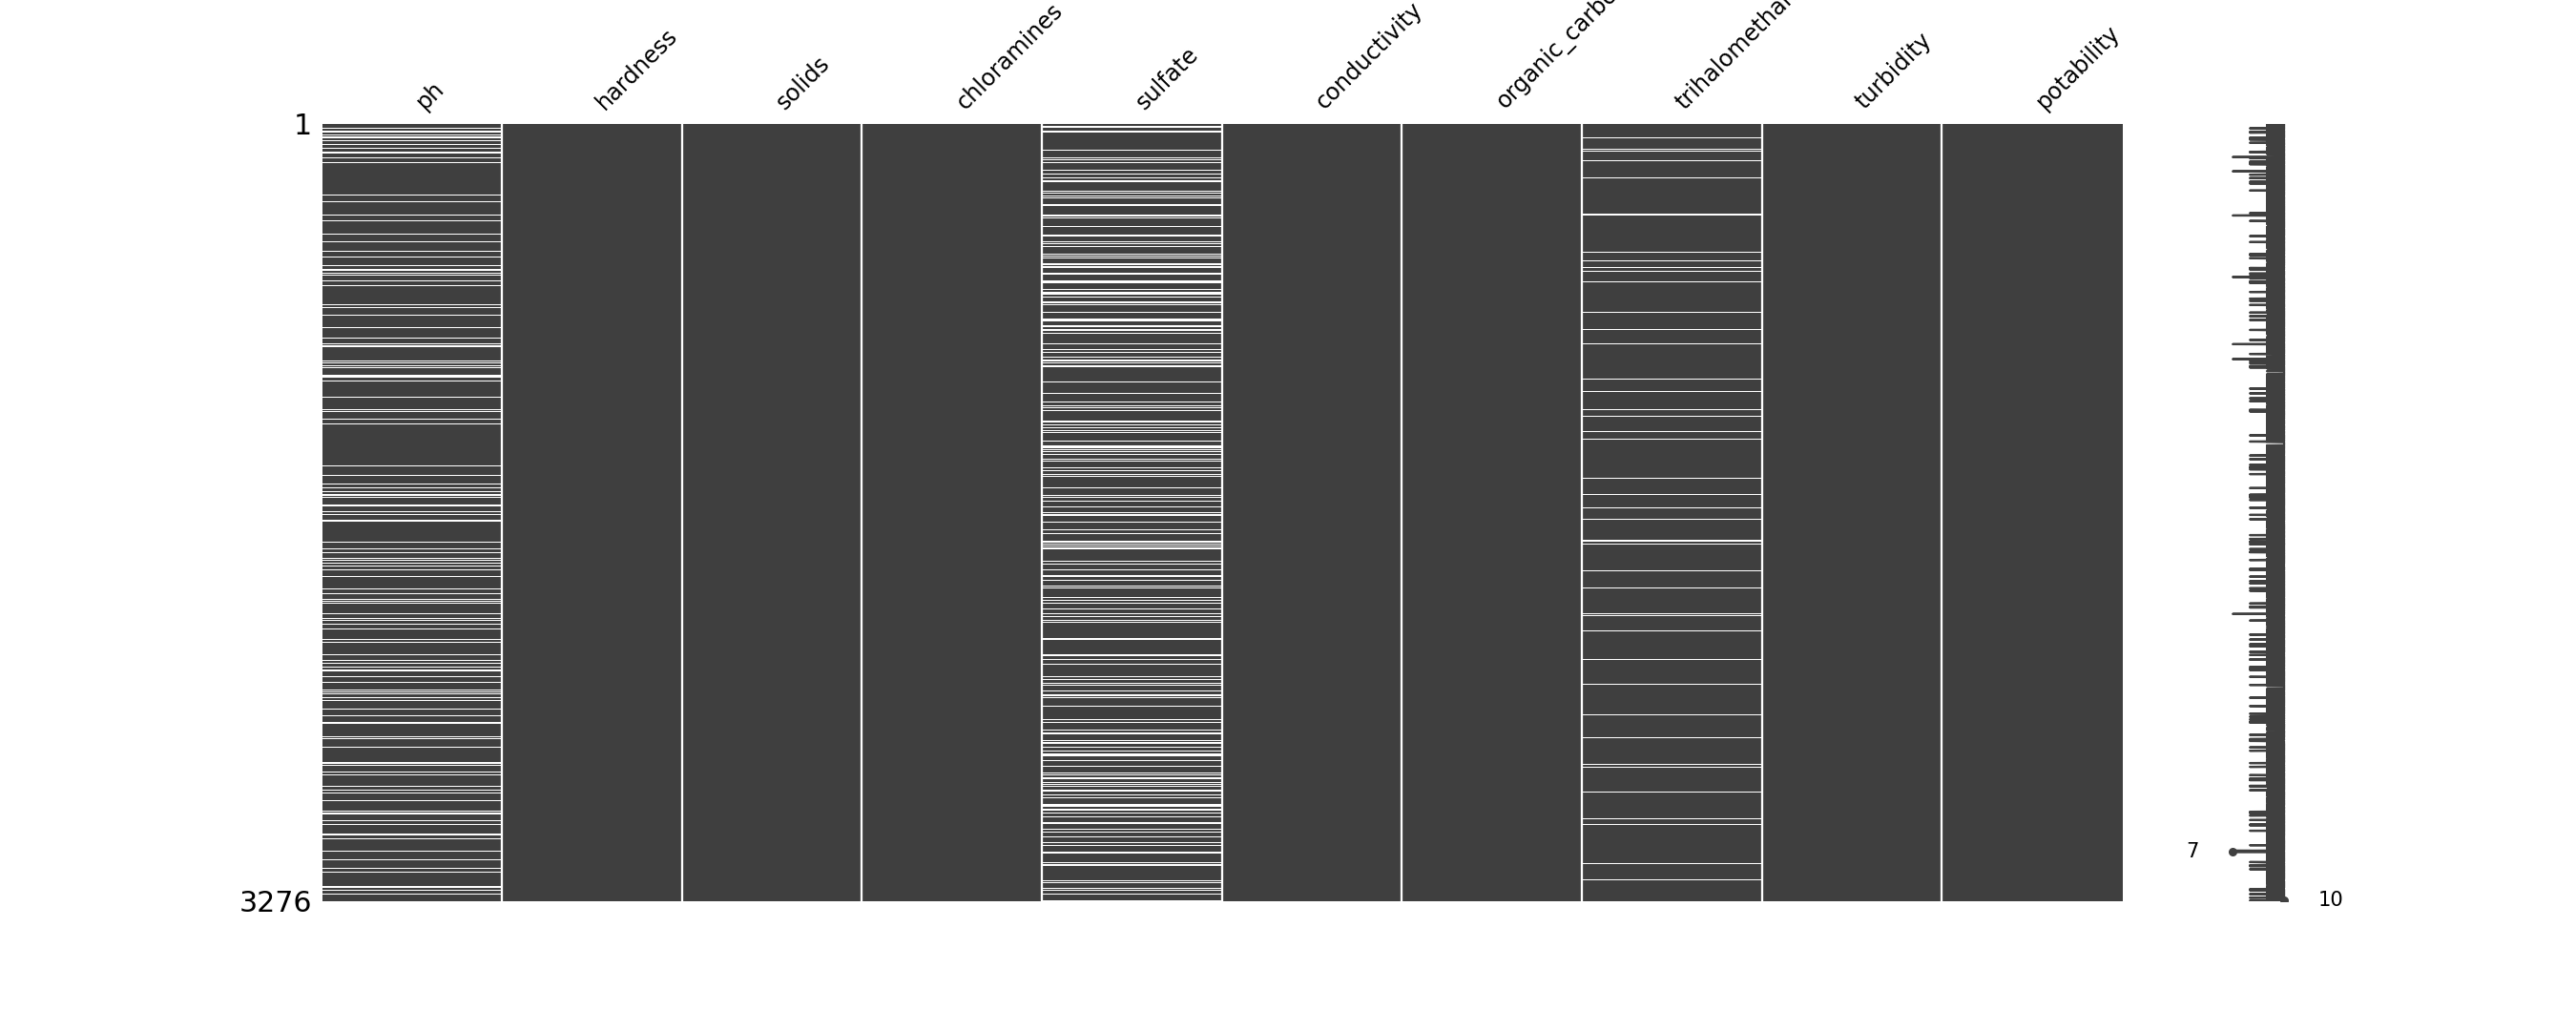

In [19]:
msno.matrix(df);

In [20]:
df.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity', 'potability'],
      dtype='object')

# Exploratory Data Analysis and Visualization

## Features | Target

In [21]:
df.duplicated(subset=None, keep='first').sum()

0

In [22]:
# 3-Target Examination
target = "potability"

# df.duplicated(subset=None, keep='first').sum()
df.drop_duplicates(keep = 'first', inplace = True)

# df = df.dropna()

X_columns = df.drop(target, axis=1).columns
X_categorical = df.drop(target, axis=1).select_dtypes('object')
X_numerical = df.drop(target, axis=1).select_dtypes('number').astype('float64')

# df[target].value_counts()
# X_columns
# X_numerical.columns
# X_categorical.columns
# X_numerical.columns.values

In [23]:
df[target].value_counts()

0    1998
1    1278
Name: potability, dtype: int64

In [24]:
X_columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype='object')

In [25]:
X_numerical.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype='object')

In [26]:
X_categorical.columns

Index([], dtype='object')

In [27]:
X_numerical.columns.values

array(['ph', 'hardness', 'solids', 'chloramines', 'sulfate',
       'conductivity', 'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype=object)

## Numerical Features

<IPython.core.display.Javascript object>


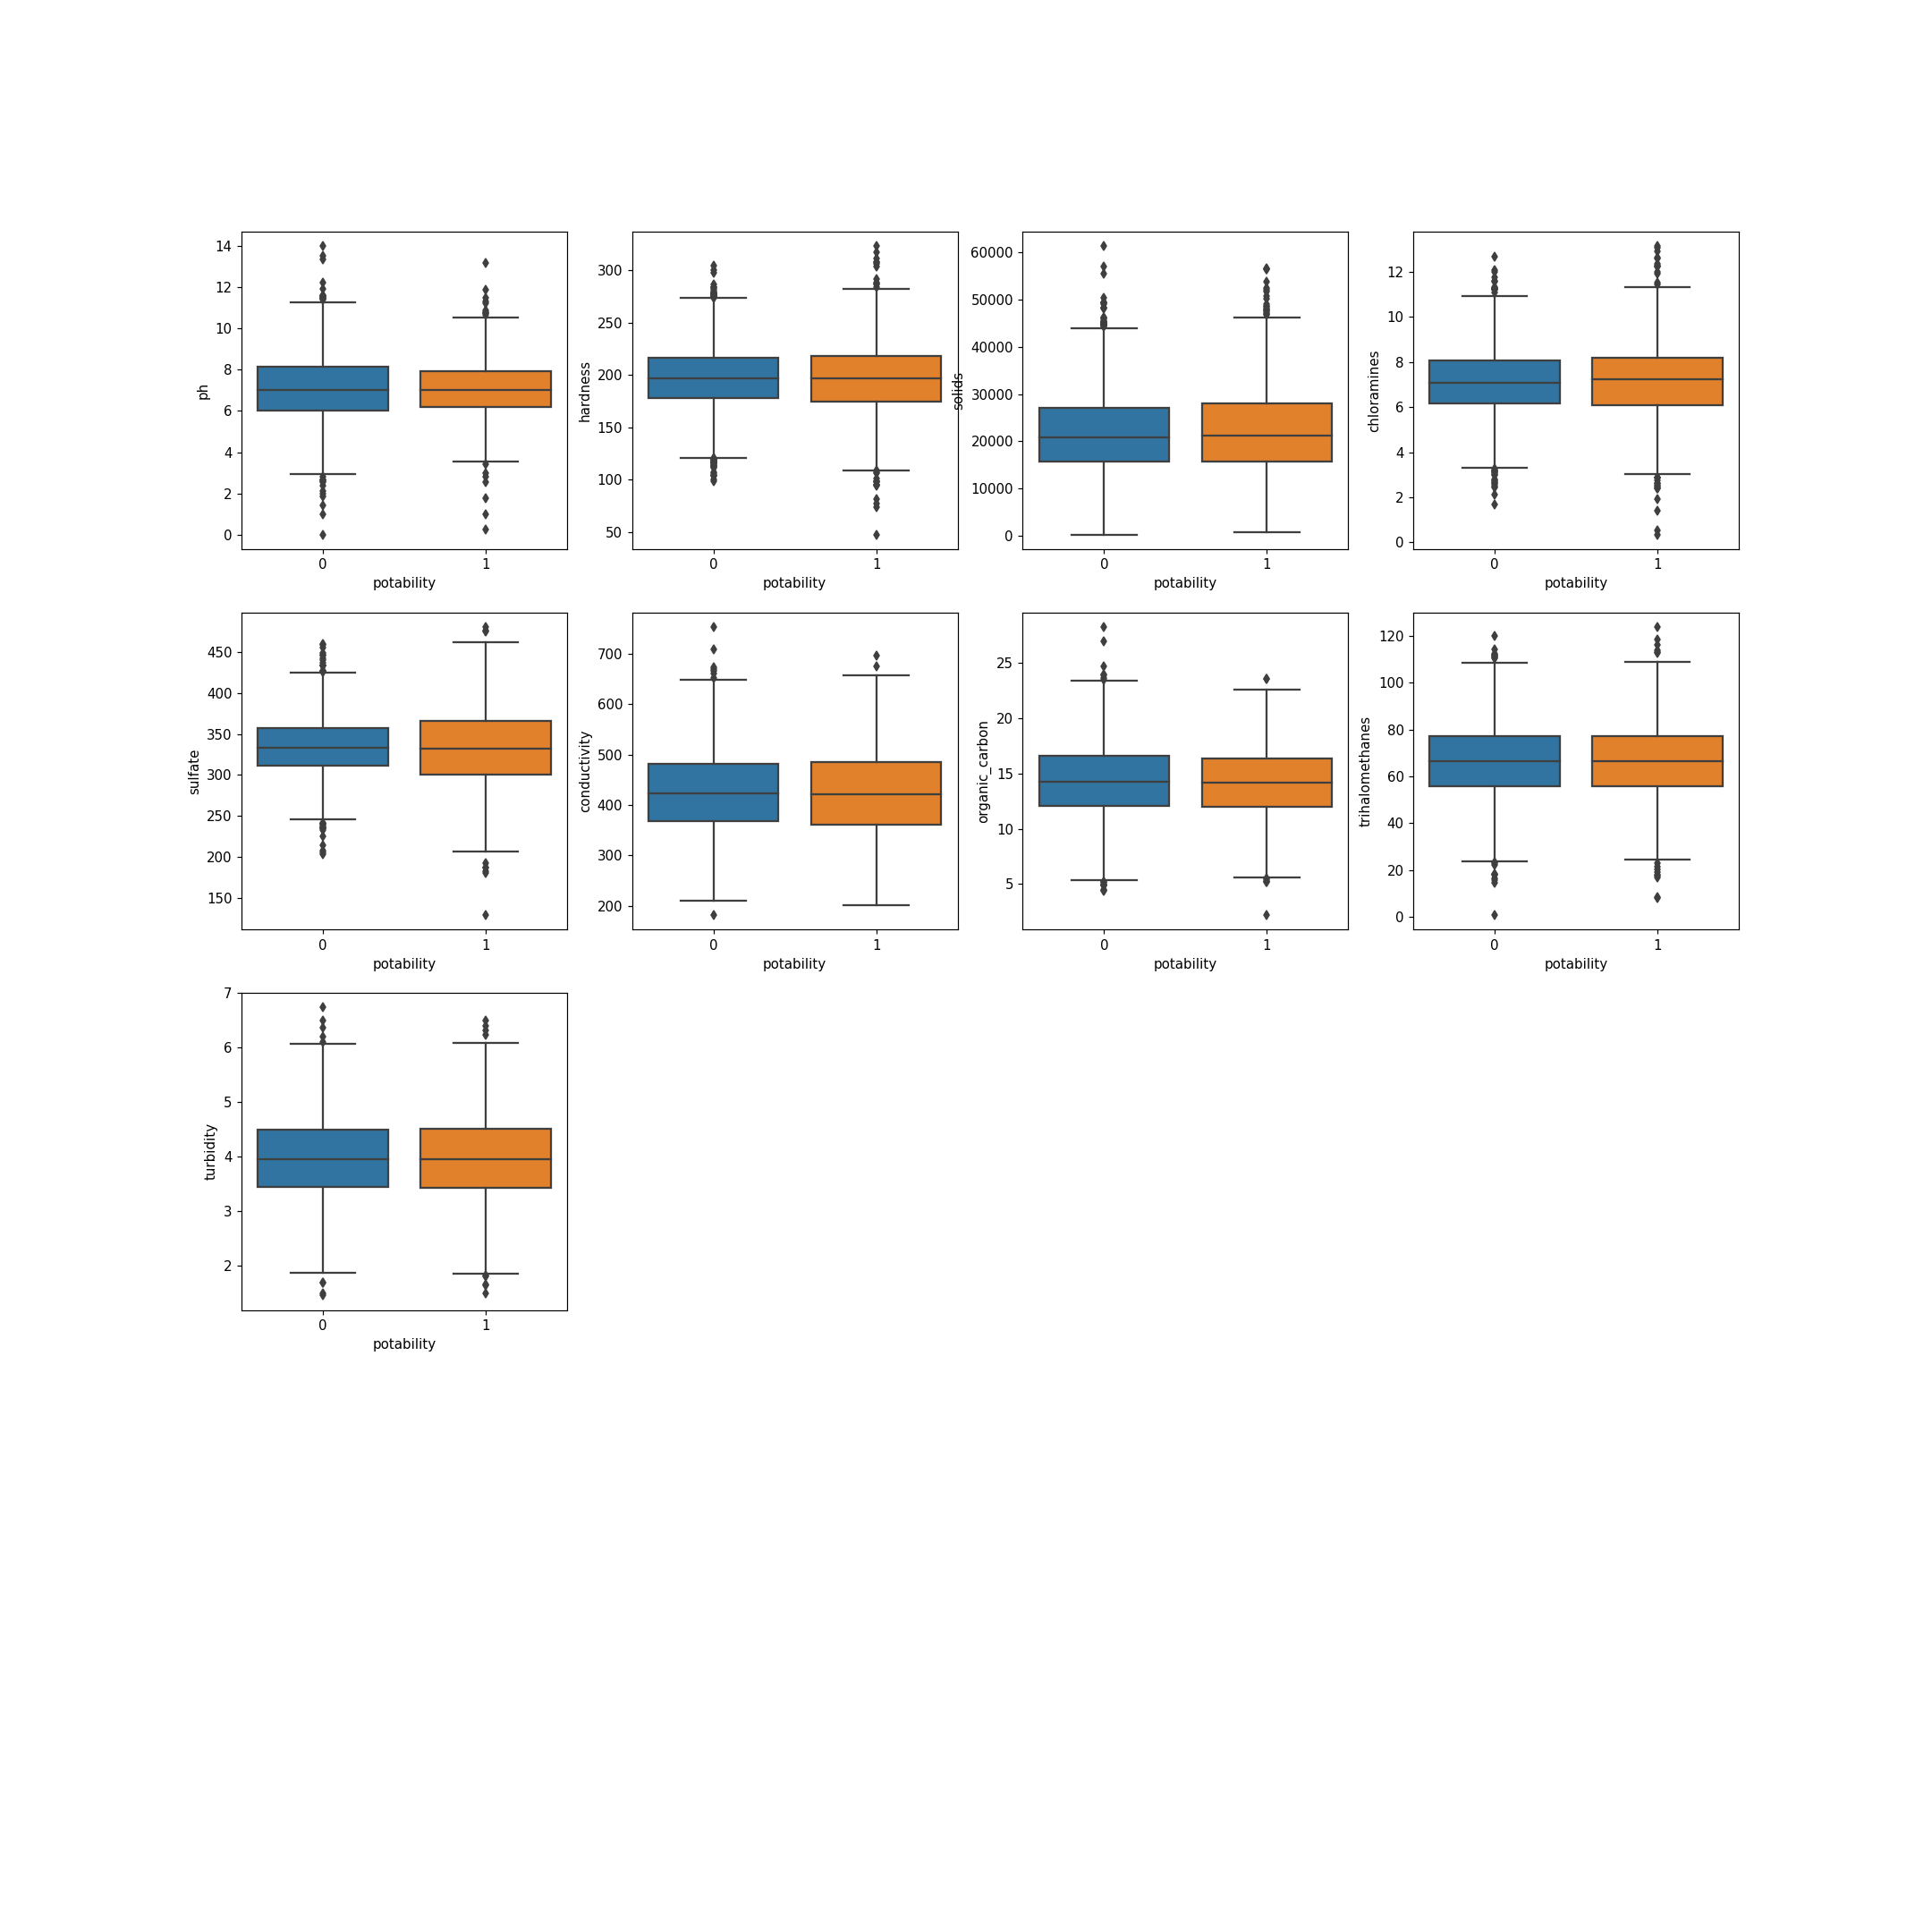

In [28]:
index = 0
plt.figure(figsize=(20,20))
for feature in X_numerical.columns:
    if feature != target:
        index += 1
        plt.subplot(4,4,index)
        sns.boxplot(x=target,y=feature,data=df);

<IPython.core.display.Javascript object>


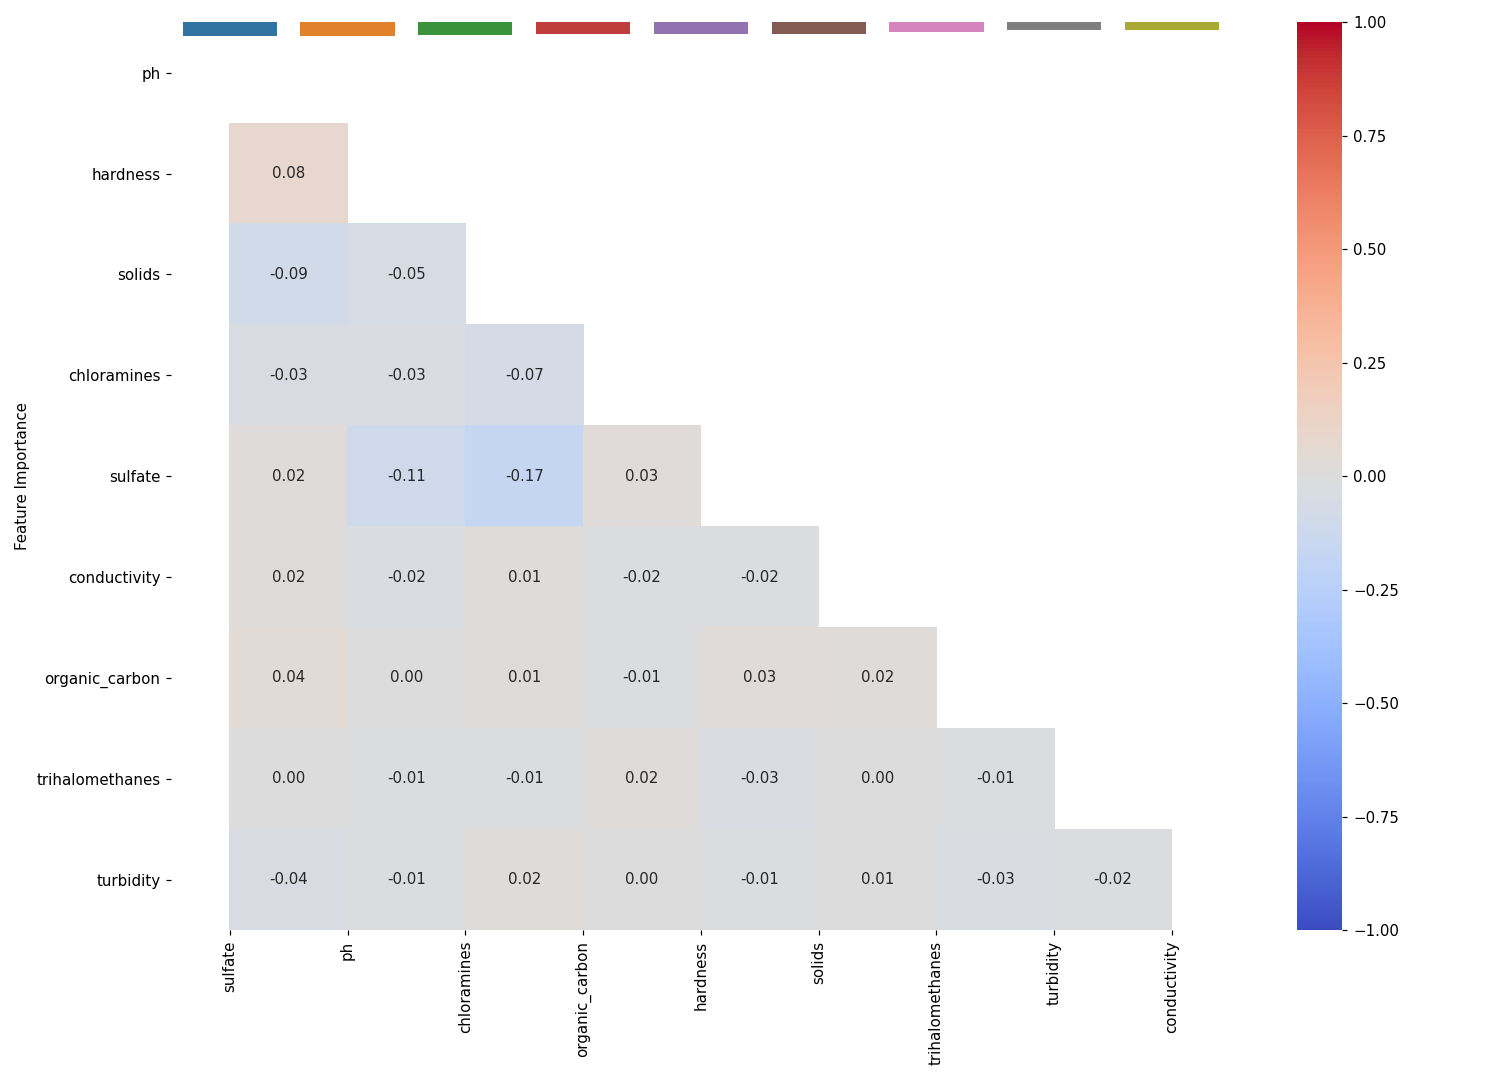

In [29]:
matrix = np.triu(X_numerical.corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (X_numerical.corr(), annot=True, 
             fmt= '.2f', vmin=-1, vmax=1, center=0, 
             cmap='coolwarm',mask=matrix, ax=ax);

# Model Selection

## Train | Test Split & Scaling

In [30]:
# 10-Train|Test Split, Dummy 

# # Before dummy: 
# make_dtype_object = df[['categorical1','categorical2']].astype('object')

X_columns_ = df.drop(target, axis=1).columns
X_categorical_ = df.drop(target, axis=1).select_dtypes('object')
X_numerical_ = df.drop(target, axis=1).select_dtypes('number').astype('float64')

###############################################################################

if (df.dtypes==object).any():
    dummied = pd.get_dummies(X_categorical_, drop_first=True)
    X = pd.concat([X_numerical_, dummied[dummied.columns]], axis=1)
    
else:
    X = df.drop(target, axis=1).astype('float64')

y = df[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42)

###############################################################################

# # 11-MinMax Scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 11-Standart Scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

###############################################################################

In [31]:
imputer = SimpleImputer(strategy='median') # median imputation ('mean' for mean and 'most_frequent' for mode imputations)

imputer.fit(X_train) # SimpleImputer() learns the median values from the train data

X_train = imputer.transform(X_train) # replace missing values with medians

X_test = imputer.transform(X_test) # replace missing values with medians

<IPython.core.display.Javascript object>

In [32]:
# 11-Standart Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Implement DT and Evaluate¶

In [33]:
## Cross Validation 
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer

cv_model = DecisionTreeClassifier(random_state=42)
scores = cross_validate(cv_model, X_train, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

test_accuracy          0.593
test_precision_macro   0.577
test_recall_macro      0.578
test_f1_macro          0.577
dtype: float64

In [34]:
# Simple Classifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42).fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
log_acc, log_recall = calc_predict()
get_report()

Model: <bound method BaseEstimator.get_params of DecisionTreeClassifier(random_state=42)> 


Train:
rmse: 0.0
accuracy: 1.0
roc_auc_score: 1.0
roc_auc_recall_precision_score: 0.5625037393801603 

confusion_matrix:

 [[1586    0]
 [   0 1034]] 

classification_report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1586
           1       1.00      1.00      1.00      1034

    accuracy                           1.00      2620
   macro avg       1.00      1.00      1.00      2620
weighted avg       1.00      1.00      1.00      2620
 


Test:
rmse: 0.6486383486327902
accuracy: 0.5792682926829268
roc_auc_score: 0.5622712080216458
roc_auc_recall_precision_score: 0.5625037393801603 

confusion_matrix:

 [[259 153]
 [123 121]] 

classification_report:

               precision    recall  f1-score   support

           0       0.68      0.63      0.65       412
           1       0.44      0.50      0.47       244

    accuracy       

In [35]:
feature_importances()

,sulfate,ph,chloramines,organic_carbon,hardness,solids,trihalomethanes,turbidity,conductivity
Feature Importance,0.139,0.135,0.130,0.116,0.115,0.114,0.096,0.081,0.074


In [36]:
feature_importances_bar()

## Implement Logistic Regression and Evaluate¶

In [37]:
## Model Evaluate¶

# 1-Logistic Regression
params = {"penalty" : ["l1", "l2", "elasticnet"],
          "l1_ratio" : np.linspace(0, 1, 20),
          "C" : np.logspace(0, 10, 20)}
model = GridSearchCV(LogisticRegression(random_state=42), 
                     params, 
                     cv=10).fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)
log_acc, log_recall = calc_predict()
get_report()
# train_control_table()
# test_control_table()
# feature_importances()
# feature_importances_bar()

# # Model tunning
# tuned_model = LogisticRegression(penalty = penalty, 
#                                C = C, 
#                                l1_ratio = l1_ratio, 
#                                solver='saga', 
#                                max_iter=5000).fit(X_train_scaled, y_train)
# y_test_pred = tuned_model.predict(X_test_scaled)

Model: <bound method BaseEstimator.get_params of GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.00000000e+00, 3.35981829e+00, 1.12883789e+01, 3.79269019e+01,
       1.27427499e+02, 4.28133240e+02, 1.43844989e+03, 4.83293024e+03,
       1.62377674e+04, 5.45559478e+04, 1.83298071e+05, 6.15848211e+05,
       2.06913808e+06, 6.95192796e+06, 2.33572147e+07, 7.84759970e+07,
       2.63665090e+08, 8.85866790e+08, 2.97635144e+09, 1.00000000e+10]),
                         'l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                         'penalty': ['l1', 'l2', 'elasticnet']})> 

model.best_params_: {'C': 1.0, 'l1_ratio': 0.0, 'penalty': 'l2'} 

Train:
rmse: 0.6282169120213322
accuracy: 0.60534351145

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

<IPython.core.display.Javascript object>


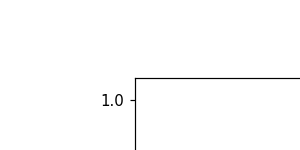

<IPython.core.display.Javascript object>


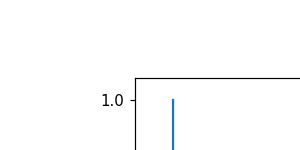

<IPython.core.display.Javascript object>


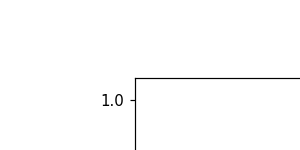

<IPython.core.display.Javascript object>


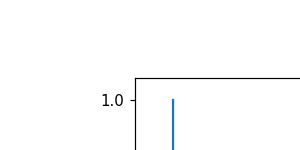

In [38]:
#print(model)
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_roc_curve(model, X_train_scaled, y_train);
plot_precision_recall_curve(model, X_train_scaled, y_train);

plot_roc_curve(model, X_test_scaled, y_test);
plot_precision_recall_curve(model, X_test_scaled, y_test);

# Implement KNN and Evaluate

In [39]:
## Model Evaluate¶

# 1-KNN Classification
params = {"n_neighbors": np.arange(1, 30)}
model = GridSearchCV(KNeighborsClassifier(), 
                    params, 
                    cv=10).fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
# knn_acc, knn_recall = calc_predict()
get_report()

Model: <bound method BaseEstimator.get_params of GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})> 

model.best_params_: {'n_neighbors': 25} 

Train:
rmse: 0.569585358761995
accuracy: 0.6755725190839694
roc_auc_score: 0.7339657203626511
roc_auc_recall_precision_score: 0.5488232081832506 

confusion_matrix:

 [[1485  101]
 [ 749  285]] 

classification_report:

               precision    recall  f1-score   support

           0       0.66      0.94      0.78      1586
           1       0.74      0.28      0.40      1034

    accuracy                           0.68      2620
   macro avg       0.70      0.61      0.59      2620
weighted avg       0.69      0.68      0.63      2620
 


Test:
rmse: 0.581734161061856
accuracy: 0.6615853658536586
roc_auc_score: 0.6561803676587618
roc_auc_recall_precision_score: 0.5

<IPython.core.display.Javascript object>


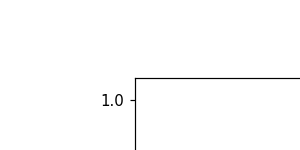

<IPython.core.display.Javascript object>


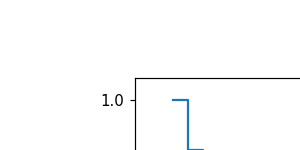

<IPython.core.display.Javascript object>


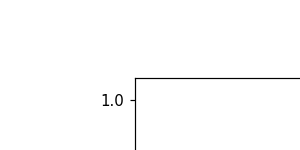

<IPython.core.display.Javascript object>


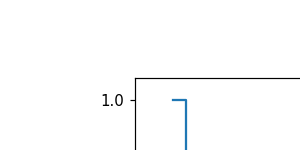

In [40]:
#print(model)
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_roc_curve(model, X_train_scaled, y_train);
plot_precision_recall_curve(model, X_train_scaled, y_train);

plot_roc_curve(model, X_test_scaled, y_test);
plot_precision_recall_curve(model, X_test_scaled, y_test);

In [41]:
# KNN Classification
params = {"n_neighbors": np.arange(1, 30), 
          "p": [1, 2]}
model = GridSearchCV(KNeighborsClassifier(), 
                     params, 
                     cv=10).fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
# knn_acc, knn_recall = calc_predict()
get_report()

Model: <bound method BaseEstimator.get_params of GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'p': [1, 2]})> 

model.best_params_: {'n_neighbors': 16, 'p': 1} 

Train:
rmse: 0.5529242179898568
accuracy: 0.6942748091603054
roc_auc_score: 0.7582711150028904
roc_auc_recall_precision_score: 0.5024527598497642 

confusion_matrix:

 [[1500   86]
 [ 715  319]] 

classification_report:

               precision    recall  f1-score   support

           0       0.68      0.95      0.79      1586
           1       0.79      0.31      0.44      1034

    accuracy                           0.69      2620
   macro avg       0.73      0.63      0.62      2620
weighted avg       0.72      0.69      0.65      2620
 


Test:
rmse: 0.5843487097907776
accuracy: 0.6585365853658537
roc_auc_score: 0.6272

<IPython.core.display.Javascript object>


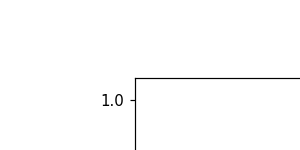

<IPython.core.display.Javascript object>


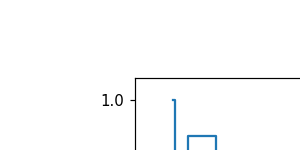

<IPython.core.display.Javascript object>


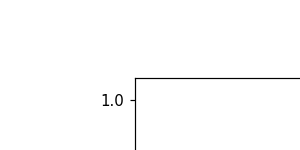

<IPython.core.display.Javascript object>


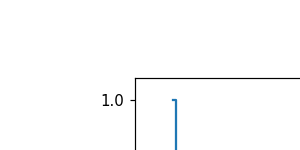

In [42]:
#print(model)
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_roc_curve(model, X_train_scaled, y_train);
plot_precision_recall_curve(model, X_train_scaled, y_train);

plot_roc_curve(model, X_test_scaled, y_test);
plot_precision_recall_curve(model, X_test_scaled, y_test);

In [43]:
# KNN Classification
params = {"n_neighbors": np.arange(1, 50), 
          "p": [1,2], 
          "weights": ['uniform', "distance"]}
model = GridSearchCV(KNeighborsClassifier(), 
                     params, 
                     cv=10).fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
knn_acc, knn_recall = calc_predict()
get_report()

Model: <bound method BaseEstimator.get_params of GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']})> 

model.best_params_: {'n_neighbors': 40, 'p': 2, 'weights': 'distance'} 

Train:
rmse: 0.0
accuracy: 1.0
roc_auc_score: 1.0
roc_auc_recall_precision_score: 0.5567769185021703 

confusion_matrix:

 [[1586    0]
 [   0 1034]] 

classification_report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1586
           1       1.00      1.00      1.00      1034

    accuracy                           1.00      2620
   macro avg       1.00      1.00      1.00      2620
weighted avg       1.00      1.00     

<IPython.core.display.Javascript object>


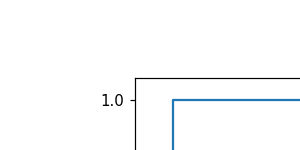

<IPython.core.display.Javascript object>


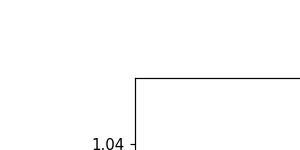

<IPython.core.display.Javascript object>


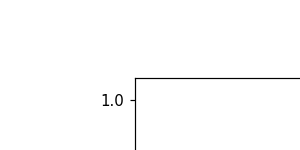

<IPython.core.display.Javascript object>


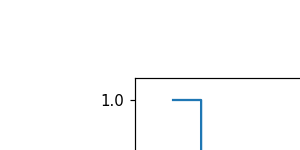

In [44]:
#print(model)
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_roc_curve(model, X_train_scaled, y_train);
plot_precision_recall_curve(model, X_train_scaled, y_train);

plot_roc_curve(model, X_test_scaled, y_test);
plot_precision_recall_curve(model, X_test_scaled, y_test);

## Implement SVM and Evaluate

In [ ]:
# SVM Classification
from sklearn.model_selection import GridSearchCV
params = {'C': [0.1,1, 10, 100, 1000],
          'gamma': ["scale", "auto", 1,0.1,0.01,0.001,0.0001],
          'kernel': ['rbf']}
model = GridSearchCV(SVC(random_state=42), 
                     params, 
                     verbose=3, 
                     refit=True, 
                     cv=10).fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
svm_acc, svm_recall = calc_predict()
get_report()

In [55]:
get_report()





Model: <bound method BaseEstimator.get_params of GridSearchCV(cv=10, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001,
                                   0.0001],
                         'kernel': ['rbf']},
             verbose=3)> 

model.best_params_: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} 

Train:
rmse: 0.40840408069676654
accuracy: 0.833206106870229


confusion_matrix:

 [[1513   73]
 [ 364  670]] 

classification_report:

               precision    recall  f1-score   support

           0       0.81      0.95      0.87      1586
           1       0.90      0.65      0.75      1034

    accuracy                           0.83      2620
   macro avg       0.85      0.80      0.81      2620
weighted avg       0.84      0.83      0.83      2620
 


Test:
rmse: 0.581734161061856
accuracy: 0.6615853658536586


confusion_matrix:

 [[324  88]
 [134 110]] 

classificat

<IPython.core.display.Javascript object>


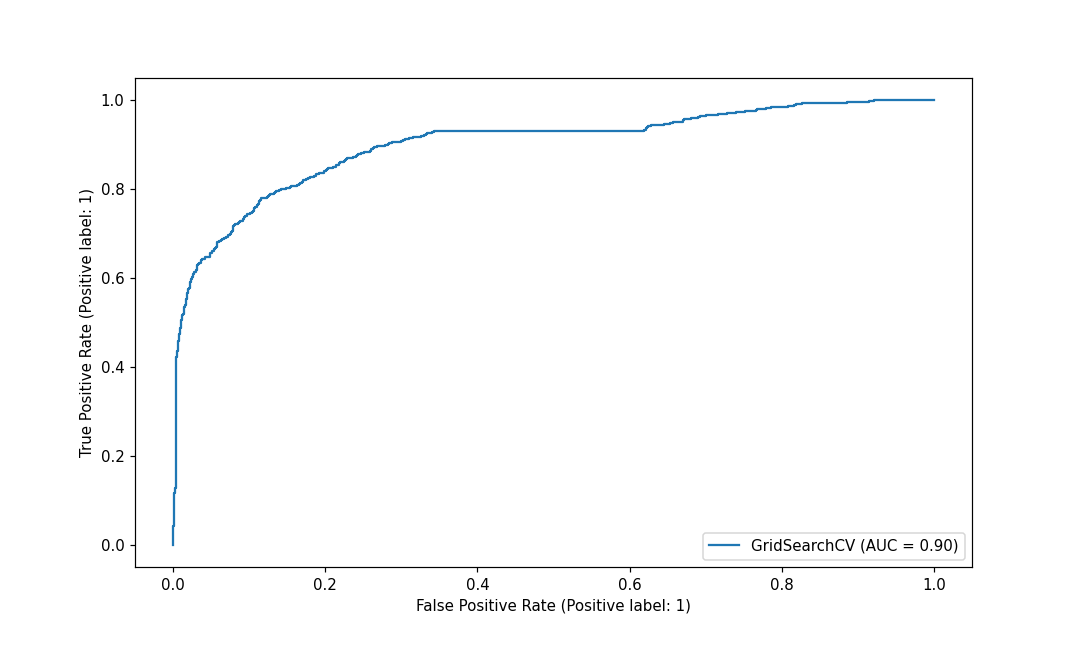

<IPython.core.display.Javascript object>


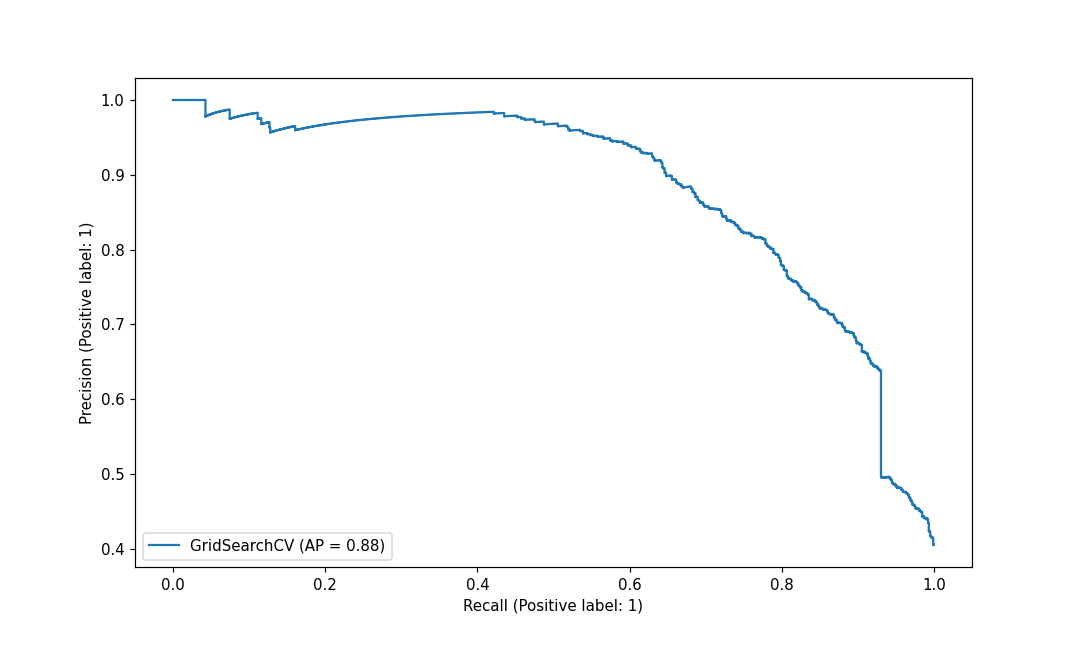

<IPython.core.display.Javascript object>


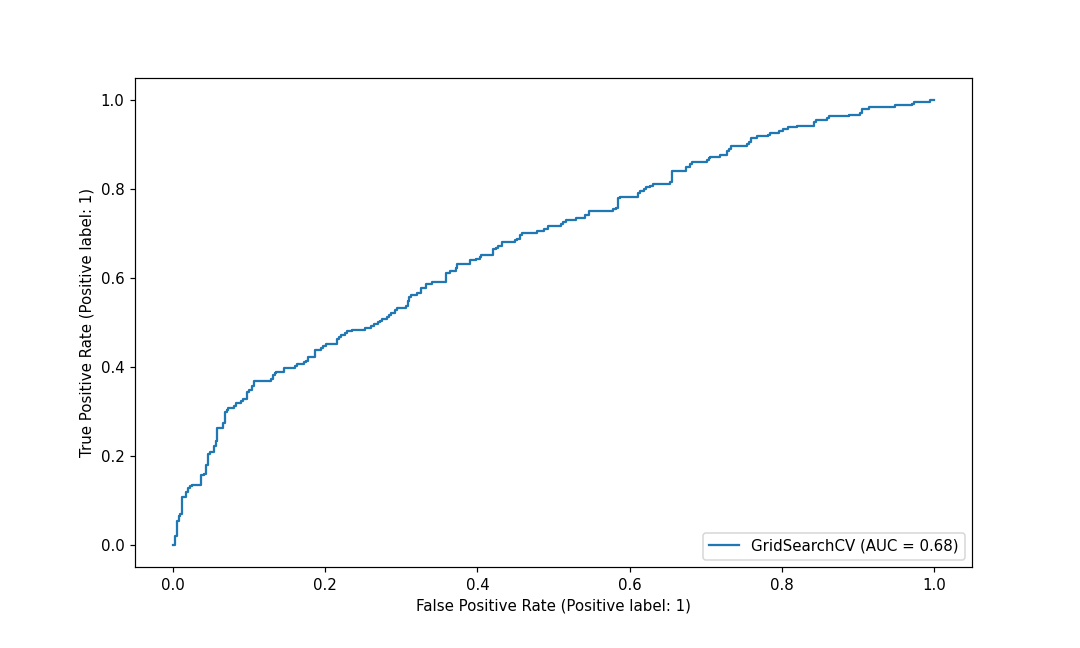

<IPython.core.display.Javascript object>


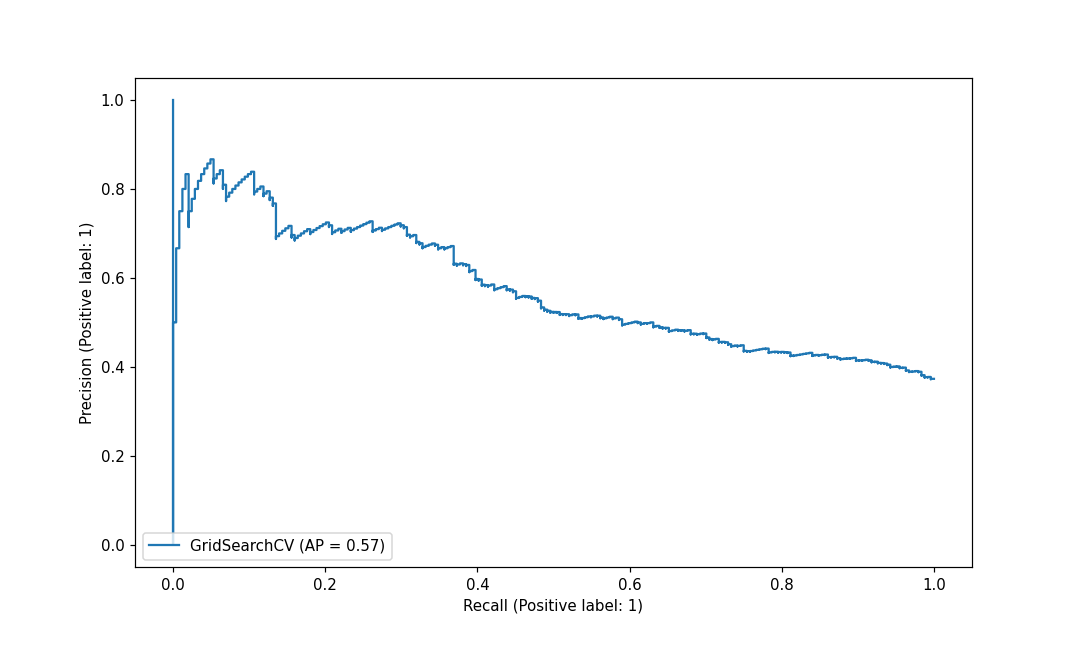

In [58]:
#print(model)
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_roc_curve(model, X_train_scaled, y_train);
plot_precision_recall_curve(model, X_train_scaled, y_train);

plot_roc_curve(model, X_test_scaled, y_test);
plot_precision_recall_curve(model, X_test_scaled, y_test);

## Implement XGBoost and Evaluate

In [59]:
from xgboost import XGBClassifier
params = {"n_estimators":[100, 300],
          "max_depth":[3,5,6], 
          "learning_rate": [0.1, 0.3],
          "subsample":[0.5, 1],
          "colsample_bytree":[0.5, 1]}
model = GridSearchCV(XGBClassifier(random_state=42), 
                     params, 
                     scoring="f1", 
                     verbose=2, 
                     n_jobs=-1,
                     cv=10).fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
xg_acc, xg_recall = calc_predict()
get_report()

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[18:51:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model: <bound method BaseEstimator.get_params of GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
  

In [60]:
#print(model)
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
plot_roc_curve(model, X_train_scaled, y_train);
plot_precision_recall_curve(model, X_train_scaled, y_train);

plot_roc_curve(model, X_test_scaled, y_test);
plot_precision_recall_curve(model, X_test_scaled, y_test);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Implement RandomForest and Evaluate

In [ ]:
# RandomForest Classification
params = {"max_depth": [2,5,8,10],
          "max_features": [2,5,8],
          "n_estimators": [10,500,1000],
          "min_samples_split": [2,5,10]}
model = GridSearchCV(RandomForestClassifier(random_state=42), 
                     params, 
                     n_jobs=-1, 
                     verbose=2, 
                     refit=True,
                     cv=10).fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
rf_acc, rf_recall = calc_predict()
get_report()

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


In [ ]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
model = gridCV_model
plot_roc_curve(model, X_train_scaled, y_train);
plot_precision_recall_curve(model, X_train_scaled, y_train);

model = gridCV_model
plot_roc_curve(model, X_test_scaled, y_test);
plot_precision_recall_curve(model, X_test_scaled, y_test);

# Data Preprocessing

# Visually compare models based on your chosen metric

# Chose best model and make a random prediction

In [ ]:
compare = pd.DataFrame({"Model": ["LR", "KNN", "SVM", "DT", "RF"],
                        "Accuracy": [dt_acc, log_acc, knn_acc, svm_acc, xg_acc, rf_acc],
                        "Recall": [dt_recall, log_recall, knn_recall, svm_recall, xg_recall, rf_recall]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.2f}'.format(width),             # set variable to display, 2 decimals
                ha='left',                         # horizontal alignment
                va='center')                       # vertical alignment
    
plt.figure(figsize=(14,10))
plt.subplot(211)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(212)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()